# Project 2: Predict the Next Frames

Recurrent Neural Network is developed for processing variable length sequences of inputs, e.g., videos. Since you have already learned about RNN in the class, now you will apply it to an interesting task: predict the next frames of a video. Specifically, given the first half of a video, you will use RNN to predict the second half. 

Submission Instructions:
Upload a ZIP archive with the completed jupyter notebook and a report to BlackBoard before the deadline.
- Notebook: your implementation of RNN.
- Report: everything else, containing the analysis of your code and qualitative/quantitative results.

This project is due by **11:59pm EDT on October 31st 2021**.

## 1. Package

Let's first import all the packages that you will need.

- **torch, torch.nn, torch.nn.functional** are the fundamental modules in pytorch library, supporting Python programs that facilitates building deep learning projects.
- **torchvision** is a library for Computer Vision that goes hand in hand with PyTorch
- **numpy** is the fundamental package for scientific computing with Python programs.
- **PIL, matplotlib** are libraries to plot graphs and save images in Python.
- **os, random** are the standard modules in Python.
- **argparse** is a library for writing user-friendly command-line interfaces.

In [1]:
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data as data
from PIL import Image
import os
import matplotlib.pyplot as plt
import argparse
import random
from project2_utils import *

# Speicify which gpu to use
gpu_ids = "0" # You can change it to other gpu id, e.g., "1" or "2" if working on a multi-gpu machine
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_ids

print("Import packages successfully!")

Import packages successfully!


## 2. Dataset

You will use a moving digits dataset for this project.

Let's first use ``torch.utils.data.Dataset`` to load it.

Number of training examples: 10000
Number of testing examples: 1000


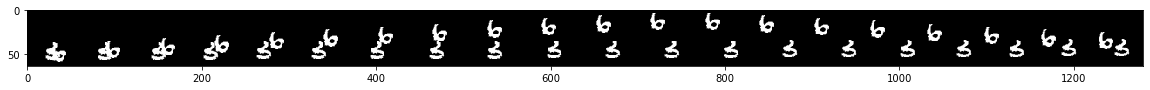

In [2]:
# the root directory of data 
root = '/u/cs298/project2/data'

# load dataset
train_set = MovingDigits(os.path.join(root, 'train.gz'), is_train=True)
test_set = MovingDigits(os.path.join(root, 'test.pt'), is_train=False)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=1,
                 shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=1,
                shuffle=False)

print ("Number of training examples: " + str(train_set.__len__()))
print ("Number of testing examples: " + str(test_set.__len__()))

# get some random training images
dataiter = iter(train_loader)
seq, seq_target = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    npimg = (npimg * 255).transpose(1,2,0).astype(np.uint8)
    plt.figure(figsize = (20,20))
    plt.imshow(npimg, interpolation='nearest')
    plt.show()

# show images
grid = torchvision.utils.make_grid(torch.cat((seq[0], seq_target[0]), 0), nrow=20, padding=0)
imshow(grid)

## 3. Convolutional LSTM Cell

In the class, you have learned the idea of of vanilla Long Short-Term Memory networks (LSTM), where the detailed equations are given as follows:

<br/>

$$
\begin{align}
f_t &= \sigma_g(W_{f} \cdot [x_t, h_{t-1}] + b_f) \\
i_t &= \sigma_g(W_{i} \cdot [x_t, h_{t-1}] + b_i) \\
c_t &= f_t \circ c_{t-1} + i_t \circ \sigma_c(W_{c} \cdot [x_t, h_{t-1}] + b_c) \\
o_t &= \sigma_g(W_{o} \cdot [x_t, h_{t-1}] + b_o) \\
h_t &= o_t \circ \sigma_h(c_t)
\end{align}
$$
<br/>

Compared to the LSTM Cell covered in the class, here you are required to implement a variant of it -- ConvLSTM. This variant modifies the inner workings of the LSTM mechanism by using the convolution operation instead of simple matrix multiplication (Note: original ConvLSTM cell design may use the cell state in all the gates, here we are actually implementing a variant of it). The equations are as follows:

<br/>

$$
\begin{align}
f_t &= \sigma_g(W_{f} * [x_t, h_{t-1}] + b_f) \\
i_t &= \sigma_g(W_{i} * [x_t, h_{t-1}] + b_i) \\
c_t &= f_t \circ c_{t-1} + i_t \circ \sigma_c(W_{c} * [x_t, h_{t-1}] + b_c) \\
o_t &= \sigma_g(W_{o} * [x_t, h_{t-1}] + b_o) \\
h_t &= o_t \circ \sigma_h(c_t)
\end{align}
$$
<br/>

where $*$ denotes convolutional operation and $\circ$ denotes Hadamard product (element-wise product). The initial values are $c_0 = 0$ and $h_0 = 0$. The subscript $t$ indexes the time step. See the figure below as a reference: 

<img src="images/convlstm1.png" width="60%">

**Variables**

* $x_t \in \mathbb{R}^{d}$: input vector to the ConvLSTM unit
* $f_t \in {(0,1)}^{h}$: forget gate's activation vector
* $i_t \in {(0,1)}^{h}$: input/update gate's activation vector
* $o_t \in {(0,1)}^{h}$: output gate's activation vector
* $h_t \in {(-1,1)}^{h}$: hidden state vector also known as output vector of the LSTM unit
* $c_t \in \mathbb{R}^{h}$: cell state vector
* $W \in \mathbb{R}^{h \times d}$, $ \in \mathbb{R}^{h \times h} $ and $b \in \mathbb{R}^{h}$: weight matrices and bias vector parameters which need to be learned during training

where the superscripts $d$ and $h$ refer to the number of input features and number of hidden units, respectively.

**Activation function**
* $\sigma_g$: sigmoid function.
* $\sigma_c$: hyperbolic tangent function.
* $\sigma_h$: hyperbolic tangent function.

**Why ConvLSTM here?**
For general-purpose sequence modeling, LSTM as a special RNN structure has proven stable and powerful for modeling long-range dependencies. In this kind of RNN structure, the previous hidden state is passed to the next step of sequence. Therefore, information on previous sequence data can be held and then used to predict the future. In our case of video prediction, LSTM is adopted to hold information on the past frames, and predict the future digit movements based on the previous observation.

Although the vanilla LSTM cell has proven powerful for handling temporal correlation, it uses full connections in input-to-state and state-to-state transitions, in which no spatial information is encoded. To address this, we use a convolutional operator in the input-to-state and state-to-state transitions, such that the ConvLSTM cell can determine the future state of a certain cell in the grid by the inputs and past states of its local neighbors. With ConvLSTM, the motion of moving digits can be captured.

---

**Question:** Given the above information, now you need to implement the ``ConvLSTM`` cell (``nn.lstm()`` is not allowed to call in your implementation):


1.   Initialize the parameters in ConvLSTM Cell. You can call ``nn.Conv2d()`` to implment the convolution.
2.   Given the current states, compute and update it to get the next states (based on the equations above).
3.   Complete the state initialization function.

In [3]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Arguments
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()
        
        # YOUR CODE HERE
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = int((kernel_size[0] - 1) / 2)
        self.bias = bias
        
        self.w_c = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim, out_channels=self.hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)
        self.w_i = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim, out_channels=self.hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)
        self.w_f = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim, out_channels=self.hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)
        self.w_o = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim, out_channels=self.hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)

    def forward(self, input, cur_state): # given the input and current states, you need to get the next states
        """
        Compute and update the states.

        Arguments
        ----------
        input:
            4-D Tensor of shape (b, c, h, w)        #   batch, channel, height, width
        cur_state: 
            [h_current, c_current] input to current cell, including hidden state and cell input 
        
        
        ----------
        Output: 
            [h_next, c_next] input to next cell, including update hidden state and cell output 
        """     
        
        # YOUR CODE HERE
        
        h_cur = cur_state[0]
        c_cur = cur_state[-1]
        
        h_cur = h_cur.to("cuda")
        c_cur = c_cur.to("cuda")
        #input = input.to("cuda")
        x_h = torch.cat([input, h_cur], dim=1)
        
        ft = torch.sigmoid(self.w_f(x_h))
        it = torch.sigmoid(self.w_i(x_h))
        ct = ft * c_cur + it * torch.tanh(self.w_c(x_h))
        ot = torch.sigmoid(self.w_o(x_h))
        ht = ot * torch.tanh(ct)

        return  ht,  ct

    def init_hidden(self, batch_size, image_size):
        """
        Initialize the input states.

        Arguments
        ----------
        batch_size: int
            Number of examples in a batch.
        image_size: (int, int)
            The spatial resolution of input images.
            
        ----------
        Output: 
            [h_init, c_init] zero tensors
        
        Note: the initialized states should also be on the gpu machine
        """
        # YOUR CODE HERE
        height, width = image_size
        
        h_init = torch.zeros(batch_size, self.hidden_dim, height, width)
        c_init = torch.zeros(batch_size, self.hidden_dim, height, width)
        
        return (h_init, c_init)


## 4. Encoder-Decoder Sequnce-to-Sequence Architecture

We follow the design patterns of RNNs that map a variable-length sequence to another variable-lenght sequence (in the class slides). An encoder that contains two ConvLSTM cells extract the "context" that represents the motion summary of the input sequential images and is given as input to the decoder RNN, which also contains two ConvLSTM cells. The network architecutre is as follows:

<br/>

Input ---> ConvLSTM 1 ---> ConvLSTM 2 ---> Encoded State ---> ConvLSTM 3 ---> ConvLSTM 4 ---> 3D CNN decoder ---> Output

<br/>

* **Input:** In the dataset, the size of input image is a tensor $ X \in \mathbb{R}^{B \times 1 \times 64 \times 64}$, where $B$ denotes the batch size. Generally, the input shape of a particular time step is ``[batch_size, num_channel, height, width]`` . ``Width`` and ``height`` are the image size, time step means which frame the network is processing.


* **Encoder**
  
  * ConvLSTM Encoder 1: the output shape is ``[batch_size, num_hidden_dim,  height, width]`` , where ``num_hidden_dim`` is the output dimension of parameters.
  * ConvLSTM Encoder 2: the output shape is ``[batch_size, num_hidden_dim, height, width]`` .


* **Decoder**
  * ConvLSTM Decoder 3: the output shape is ``[batch_size, num_hidden_dim,  height, width]`` .
  * ConvLSTM Decoder 4: the output shape is ``[batch_size, num_hidden_dim,  height, width]`` .


* **3D CNN Decoder:**
Since we want to regress images from the hidden states, we need to transform the feature maps from decoder into actual predictions. 
To achieve this we implement a 3D-CNN layer: 1) Take as input ``[num_hidden_dim, height, width]`` for each example in batch and time step 2) Iterate over the $n$ hidden states 3) Output ``[num_channel, height, width]`` per iteration, which is the predicted frame.

  * Sigmoid layer: For the activation layer, as we normalized images into [0,1] at the beginning, we use a sigmoid actvation function to transform the output values of 3D-CNN layer into [0,1] as well. 

**How to predict the next $n$ frames?**

Rather than predict all future frames in one-go, you will feed the "context" obtained from encoder into ConvLSTM decoder to get a final hidden state at one time. This final hidden state will then go through the 3D CNN decoder to get an actual predicted frame. For the first predicted frame, the output from the encoder can be used as "context". For the $n$-th predicted frame ($n>1$), the final hidden state of ($n$-1)-th frame can be used as "context" to input to the ConvLSTM decoder. By iterating $n$ times, the network can predict the next $n$ frames.

In this case, you can produce any number of predictions in the future without having to change the architecture.

---

**Question:** Given the above information, you will need to build the encoder-decoder network:


1.   Initialize the parameters in ``EncoderDecoderConvLSTM``. You can call ``nn.Conv3d()`` to implment the 3D CNN layer and use the above ConvLSTM cell to build the encoder and decoder.
2.   Define the encoder->decoder forward pass in ``autoencder()``.
3.   Complete the forward pass of the whole network: first initialize the states and then gradually update them. (Hint: you can call ``init_hidden()`` function in ConvLSTM cell for state initialization)

In [4]:
class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, num_hidden_dim, in_channel):
        super(EncoderDecoderConvLSTM, self).__init__()

        """ ARCHITECTURE 

        # Encoder (ConvLSTM)
        # Encoded Vector (final hidden state of encoder)
        # Decoder (ConvLSTM) - takes Encoded Vector as input
        # Decoder (3D CNN) - regresses frames from hidden states

        """
        
        # YOUR CODE HERE
        
        self.num_hidden_dim = num_hidden_dim
        self.in_channel = in_channel
        
        self.encoder_1 = ConvLSTMCell(self.in_channel, self.num_hidden_dim, kernel_size=(3,3), bias=True)
        self.encoder_2 = ConvLSTMCell(self.num_hidden_dim, self.num_hidden_dim, kernel_size=(3,3), bias=True)
        self.decoder_3 = ConvLSTMCell(self.num_hidden_dim, self.num_hidden_dim, kernel_size=(3,3), bias=True)
        self.decoder_4 = ConvLSTMCell(self.num_hidden_dim, self.num_hidden_dim, kernel_size=(3,3), bias=True)
        
        self.decoder_CNN = nn.Conv3d(in_channels=self.num_hidden_dim, out_channels=self.in_channel, kernel_size=3, padding=1, bias=True)


    def autoencoder(self, x, seq_len, future_step, States):
        """
        Build the encoder-decoder forward pass

        Arguments
        ----------
        x: 
            5-D Tensor of shape (b, t, c, h, w)       #   batch_size, time_step, num_channel, height, width
        seq_len: int
            Length of input sequence.
        future_step: int
            Length of predicted sequence.
        States: bool
            Initialized states for each cell.
        """
        
        # List to store the final hidden state of all the predicted frames 
        outputs = []
        
        # The initialized state vectors
        h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4 = States
        
        
        # encoder
        # YOUR CODE HERE
        
        for t in range(seq_len):
            h_t, c_t = self.encoder_1(x[:, t, :, :, :], [h_t, c_t])
            h_t2, c_t2 = self.encoder_2(h_t, [h_t2, c_t2])
        
        # encoded_vector: "context" from the encoder
        # YOUR CODE HERE
        encoded_vector = h_t2

        # decoder: you should store the final hidden states h_t4 from decoder in list outputs
        # YOUR CODE HERE
        
        for t in range(future_step):
            h_t3, c_t3 = self.decoder_3(encoded_vector, [h_t3, c_t3])
            h_t4, c_t4 = self.decoder_4(h_t3, [h_t4, c_t4])
            encoded_vector = h_t4
            outputs.append(h_t4)

        # regression
        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        predicted_frames = torch.nn.Sigmoid()(outputs)

        return predicted_frames

    def forward(self, x, future_seq=0):

        """
        Parameters
        ----------
        x:
            5-D Tensor of shape (b, t, c, h, w)        #   batch, time, num_channel, height, width
        future_seq:
            Length of predicted sequence
        """

        # find size of different input dimensions
        b, seq_len, _, h, w = x.size()
        
        # initialize hidden states
        # YOUR CODE HERE
        h_t, c_t = self.encoder_1.init_hidden(b, (h, w))
        h_t2, c_t2 = self.encoder_2.init_hidden(b, (h, w))
        h_t3, c_t3 = self.decoder_3.init_hidden(b, (h, w))
        h_t4, c_t4 = self.decoder_4.init_hidden(b, (h, w))
        
        States = [h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4]
        
        # autoencoder forward
        # YOUR CODE HERE
        predicted_frames = self.autoencoder(x, seq_len, future_seq, States)
        
        return predicted_frames

## 5. Training and Evaluation

We provide you helper functions for training and evaluation:

```python
    def save_img(img, args):
        """
        TODO: Save images in your checkpoint directory
        """
    
    def show_video(x, y_hat, y):
        """
        TODO: Make the predicted frames and ground truth frames as a image
        """

    def train(net, loader, criterion, optimizer, epoch, args):
        """
        TODO: Training function for each epoch
        """

    def evaluate_epoch(net, loader, criterion, epoch, args):
        """
        TODO: Evaluation function for each epoch
        """    
        
    def evaluate(net, loader, criterion, args):
        """
        TODO: Evaluation function for the whole test set
        """

    def create_optimizer(net, learning_rate):
        """
        TODO: Create optimizer for updating network parameters
        """

    def create_criterion():
        """
        TODO: Create criterion for gradients backward
        """
    def checkpoint(net, epoch, cur_loss, args):
        """
        TODO: Save your trained model as file
        """
```

Here are some examples of output, you are expected to get similar results or even better! (Top row contains the input sequence and the predicted frames, while the second row represents the input sequence and ground truth)

<img src="./images/result50.jpg" width="90%">
<img src="./images/result55.jpg" width="90%">
<img src="./images/result62.jpg" width="90%">

The Average Mean-Square Error (MSE) on the test set of a model trained with 100 epochs is around **0.0280**. 

**Question**: You can found that the results are not perfect, please write a paragraph in the report to explain why the generated frames are "fading away". 

**Bonus (10%)**: Based on the above conclusion, you could think of ways to improve your code, and explain your observations and method in the report.

---

We use ``argparse`` to manage the experimental setting, e.g., hyperparameters and data directory. You can follow the default setting or change it with your choices.

If "out-of-memory" error message occurs, you may try to reduce the batch size or hidden_dims. 

When the training is done, you can set ``args.load=True`` and ``args.eval=True`` to get both qualititative and quantitative analysis of your model.

In [5]:
def main(args):
    net = EncoderDecoderConvLSTM(num_hidden_dim=args.n_hidden_dim, in_channel=1)
    criterion = create_criterion()
    

    train_loader = torch.utils.data.DataLoader(
                     dataset=train_set,
                     batch_size=args.batch_size,
                     shuffle=True)
    test_loader = torch.utils.data.DataLoader(
                    dataset=test_set,
                    batch_size=args.batch_size,
                    shuffle=False)
    
    optimizer = create_optimizer(net, args.lr)
    
    # send net to gpu
    net.to(args.device)
    
    if args.load:
        net.load_state_dict(torch.load(os.path.join(args.ckpt_dir, 'net_best.pth')))
        print("========== load checkpoints successfully! ==========")
    
    if args.eval:
        print("========== evaluating... ==========")
        evaluate(net, test_loader, criterion, args)
        print("========== evaluation done! ==========")
        return

    
    # Training loop
    for epoch in range(1, args.epochs + 1):
        # traning function
        train(net, train_loader, criterion, optimizer, epoch, args)
        
        # Evaluation and visualization
        if epoch % args.eval_epoch == 0:
            cur_loss = evaluate_epoch(net, test_loader, criterion, epoch, args)
            # checkpointing
            checkpoint(net, epoch, cur_loss ,args)

    print('Training Done!')



if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=16, type=int, help='batch size')
    parser.add_argument('--epochs', type=int, default=100, help='number of epochs to train for')
    parser.add_argument('--eval_epoch', type=int, default=1, help='number of epochs to evaluate once')
    parser.add_argument('--n_hidden_dim', type=int, default=64, help='number of hidden dim for ConvLSTM cells')
    parser.add_argument('--n_steps_ahead', type=int, default=10, help='length of predicted sequences')
    parser.add_argument('--ckpt_dir', type=str, default='./ckpt', help='where you save trained model')
    parser.add_argument('--load', type=bool, default=False, help='whether to load the previsous checkpoint')
    parser.add_argument('--eval', type=bool, default=False, help='whether to evaluate the whole test set without training')
    
    args, unknown = parser.parse_known_args()
    
    args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if not os.path.exists(args.ckpt_dir):
        os.makedirs(args.ckpt_dir)
        
    args.best_loss = float('inf')

    # fix the random seed
    random.seed(1)
    torch.manual_seed(1)
    main(args)
    

Epoch:[1/100], Step: [0] learning_rate: 0.0001, loss: 0.2390
Epoch:[1/100], Step: [50] learning_rate: 0.0001, loss: 0.0478
Epoch:[1/100], Step: [100] learning_rate: 0.0001, loss: 0.0391
Epoch:[1/100], Step: [150] learning_rate: 0.0001, loss: 0.0421
Epoch:[1/100], Step: [200] learning_rate: 0.0001, loss: 0.0447
Epoch:[1/100], Step: [250] learning_rate: 0.0001, loss: 0.0379
Epoch:[1/100], Step: [300] learning_rate: 0.0001, loss: 0.0398
Epoch:[1/100], Step: [350] learning_rate: 0.0001, loss: 0.0426
Epoch:[1/100], Step: [400] learning_rate: 0.0001, loss: 0.0372
Epoch:[1/100], Step: [450] learning_rate: 0.0001, loss: 0.0398
Epoch:[1/100], Step: [500] learning_rate: 0.0001, loss: 0.0375
Epoch:[1/100], Step: [550] learning_rate: 0.0001, loss: 0.0372
Epoch:[1/100], Step: [600] learning_rate: 0.0001, loss: 0.0383
Average MSE loss on test dataset: 0.0396
Saving checkpoints at 1 epochs.
Epoch:[2/100], Step: [0] learning_rate: 0.0001, loss: 0.0390
Epoch:[2/100], Step: [50] learning_rate: 0.0001, l

Epoch:[10/100], Step: [200] learning_rate: 0.0001, loss: 0.0353
Epoch:[10/100], Step: [250] learning_rate: 0.0001, loss: 0.0333
Epoch:[10/100], Step: [300] learning_rate: 0.0001, loss: 0.0325
Epoch:[10/100], Step: [350] learning_rate: 0.0001, loss: 0.0340
Epoch:[10/100], Step: [400] learning_rate: 0.0001, loss: 0.0346
Epoch:[10/100], Step: [450] learning_rate: 0.0001, loss: 0.0340
Epoch:[10/100], Step: [500] learning_rate: 0.0001, loss: 0.0327
Epoch:[10/100], Step: [550] learning_rate: 0.0001, loss: 0.0331
Epoch:[10/100], Step: [600] learning_rate: 0.0001, loss: 0.0337
Average MSE loss on test dataset: 0.0335
Saving checkpoints at 10 epochs.
Epoch:[11/100], Step: [0] learning_rate: 0.0001, loss: 0.0349
Epoch:[11/100], Step: [50] learning_rate: 0.0001, loss: 0.0354
Epoch:[11/100], Step: [100] learning_rate: 0.0001, loss: 0.0345
Epoch:[11/100], Step: [150] learning_rate: 0.0001, loss: 0.0334
Epoch:[11/100], Step: [200] learning_rate: 0.0001, loss: 0.0329
Epoch:[11/100], Step: [250] learn

Epoch:[19/100], Step: [300] learning_rate: 0.0001, loss: 0.0303
Epoch:[19/100], Step: [350] learning_rate: 0.0001, loss: 0.0321
Epoch:[19/100], Step: [400] learning_rate: 0.0001, loss: 0.0325
Epoch:[19/100], Step: [450] learning_rate: 0.0001, loss: 0.0321
Epoch:[19/100], Step: [500] learning_rate: 0.0001, loss: 0.0318
Epoch:[19/100], Step: [550] learning_rate: 0.0001, loss: 0.0317
Epoch:[19/100], Step: [600] learning_rate: 0.0001, loss: 0.0322
Average MSE loss on test dataset: 0.0319
Saving checkpoints at 19 epochs.
Epoch:[20/100], Step: [0] learning_rate: 0.0001, loss: 0.0300
Epoch:[20/100], Step: [50] learning_rate: 0.0001, loss: 0.0350
Epoch:[20/100], Step: [100] learning_rate: 0.0001, loss: 0.0307
Epoch:[20/100], Step: [150] learning_rate: 0.0001, loss: 0.0324
Epoch:[20/100], Step: [200] learning_rate: 0.0001, loss: 0.0325
Epoch:[20/100], Step: [250] learning_rate: 0.0001, loss: 0.0321
Epoch:[20/100], Step: [300] learning_rate: 0.0001, loss: 0.0313
Epoch:[20/100], Step: [350] learn

Epoch:[28/100], Step: [400] learning_rate: 0.0001, loss: 0.0326
Epoch:[28/100], Step: [450] learning_rate: 0.0001, loss: 0.0303
Epoch:[28/100], Step: [500] learning_rate: 0.0001, loss: 0.0326
Epoch:[28/100], Step: [550] learning_rate: 0.0001, loss: 0.0327
Epoch:[28/100], Step: [600] learning_rate: 0.0001, loss: 0.0321
Average MSE loss on test dataset: 0.0313
Saving checkpoints at 28 epochs.
Epoch:[29/100], Step: [0] learning_rate: 0.0001, loss: 0.0290
Epoch:[29/100], Step: [50] learning_rate: 0.0001, loss: 0.0350
Epoch:[29/100], Step: [100] learning_rate: 0.0001, loss: 0.0291
Epoch:[29/100], Step: [150] learning_rate: 0.0001, loss: 0.0301
Epoch:[29/100], Step: [200] learning_rate: 0.0001, loss: 0.0293
Epoch:[29/100], Step: [250] learning_rate: 0.0001, loss: 0.0315
Epoch:[29/100], Step: [300] learning_rate: 0.0001, loss: 0.0290
Epoch:[29/100], Step: [350] learning_rate: 0.0001, loss: 0.0318
Epoch:[29/100], Step: [400] learning_rate: 0.0001, loss: 0.0294
Epoch:[29/100], Step: [450] learn

Epoch:[37/100], Step: [500] learning_rate: 0.0001, loss: 0.0294
Epoch:[37/100], Step: [550] learning_rate: 0.0001, loss: 0.0321
Epoch:[37/100], Step: [600] learning_rate: 0.0001, loss: 0.0294
Average MSE loss on test dataset: 0.0308
Saving checkpoints at 37 epochs.
Epoch:[38/100], Step: [0] learning_rate: 0.0001, loss: 0.0299
Epoch:[38/100], Step: [50] learning_rate: 0.0001, loss: 0.0293
Epoch:[38/100], Step: [100] learning_rate: 0.0001, loss: 0.0330
Epoch:[38/100], Step: [150] learning_rate: 0.0001, loss: 0.0315
Epoch:[38/100], Step: [200] learning_rate: 0.0001, loss: 0.0322
Epoch:[38/100], Step: [250] learning_rate: 0.0001, loss: 0.0296
Epoch:[38/100], Step: [300] learning_rate: 0.0001, loss: 0.0305
Epoch:[38/100], Step: [350] learning_rate: 0.0001, loss: 0.0287
Epoch:[38/100], Step: [400] learning_rate: 0.0001, loss: 0.0294
Epoch:[38/100], Step: [450] learning_rate: 0.0001, loss: 0.0322
Epoch:[38/100], Step: [500] learning_rate: 0.0001, loss: 0.0300
Epoch:[38/100], Step: [550] learn

Epoch:[46/100], Step: [600] learning_rate: 0.0001, loss: 0.0319
Average MSE loss on test dataset: 0.0303
Saving checkpoints at 46 epochs.
Epoch:[47/100], Step: [0] learning_rate: 0.0001, loss: 0.0272
Epoch:[47/100], Step: [50] learning_rate: 0.0001, loss: 0.0285
Epoch:[47/100], Step: [100] learning_rate: 0.0001, loss: 0.0281
Epoch:[47/100], Step: [150] learning_rate: 0.0001, loss: 0.0308
Epoch:[47/100], Step: [200] learning_rate: 0.0001, loss: 0.0273
Epoch:[47/100], Step: [250] learning_rate: 0.0001, loss: 0.0306
Epoch:[47/100], Step: [300] learning_rate: 0.0001, loss: 0.0314
Epoch:[47/100], Step: [350] learning_rate: 0.0001, loss: 0.0321
Epoch:[47/100], Step: [400] learning_rate: 0.0001, loss: 0.0281
Epoch:[47/100], Step: [450] learning_rate: 0.0001, loss: 0.0314
Epoch:[47/100], Step: [500] learning_rate: 0.0001, loss: 0.0271
Epoch:[47/100], Step: [550] learning_rate: 0.0001, loss: 0.0305
Epoch:[47/100], Step: [600] learning_rate: 0.0001, loss: 0.0302
Average MSE loss on test dataset:

Epoch:[56/100], Step: [0] learning_rate: 0.0001, loss: 0.0317
Epoch:[56/100], Step: [50] learning_rate: 0.0001, loss: 0.0312
Epoch:[56/100], Step: [100] learning_rate: 0.0001, loss: 0.0335
Epoch:[56/100], Step: [150] learning_rate: 0.0001, loss: 0.0310
Epoch:[56/100], Step: [200] learning_rate: 0.0001, loss: 0.0297
Epoch:[56/100], Step: [250] learning_rate: 0.0001, loss: 0.0289
Epoch:[56/100], Step: [300] learning_rate: 0.0001, loss: 0.0303
Epoch:[56/100], Step: [350] learning_rate: 0.0001, loss: 0.0301
Epoch:[56/100], Step: [400] learning_rate: 0.0001, loss: 0.0287
Epoch:[56/100], Step: [450] learning_rate: 0.0001, loss: 0.0287
Epoch:[56/100], Step: [500] learning_rate: 0.0001, loss: 0.0291
Epoch:[56/100], Step: [550] learning_rate: 0.0001, loss: 0.0283
Epoch:[56/100], Step: [600] learning_rate: 0.0001, loss: 0.0304
Average MSE loss on test dataset: 0.0295
Saving checkpoints at 56 epochs.
Epoch:[57/100], Step: [0] learning_rate: 0.0001, loss: 0.0295
Epoch:[57/100], Step: [50] learning

Epoch:[65/100], Step: [100] learning_rate: 0.0001, loss: 0.0308
Epoch:[65/100], Step: [150] learning_rate: 0.0001, loss: 0.0310
Epoch:[65/100], Step: [200] learning_rate: 0.0001, loss: 0.0319
Epoch:[65/100], Step: [250] learning_rate: 0.0001, loss: 0.0281
Epoch:[65/100], Step: [300] learning_rate: 0.0001, loss: 0.0299
Epoch:[65/100], Step: [350] learning_rate: 0.0001, loss: 0.0300
Epoch:[65/100], Step: [400] learning_rate: 0.0001, loss: 0.0271
Epoch:[65/100], Step: [450] learning_rate: 0.0001, loss: 0.0270
Epoch:[65/100], Step: [500] learning_rate: 0.0001, loss: 0.0286
Epoch:[65/100], Step: [550] learning_rate: 0.0001, loss: 0.0275
Epoch:[65/100], Step: [600] learning_rate: 0.0001, loss: 0.0274
Average MSE loss on test dataset: 0.0289
Saving checkpoints at 65 epochs.
Epoch:[66/100], Step: [0] learning_rate: 0.0001, loss: 0.0312
Epoch:[66/100], Step: [50] learning_rate: 0.0001, loss: 0.0296
Epoch:[66/100], Step: [100] learning_rate: 0.0001, loss: 0.0289
Epoch:[66/100], Step: [150] learn

Epoch:[74/100], Step: [200] learning_rate: 0.0001, loss: 0.0261
Epoch:[74/100], Step: [250] learning_rate: 0.0001, loss: 0.0273
Epoch:[74/100], Step: [300] learning_rate: 0.0001, loss: 0.0280
Epoch:[74/100], Step: [350] learning_rate: 0.0001, loss: 0.0277
Epoch:[74/100], Step: [400] learning_rate: 0.0001, loss: 0.0299
Epoch:[74/100], Step: [450] learning_rate: 0.0001, loss: 0.0289
Epoch:[74/100], Step: [500] learning_rate: 0.0001, loss: 0.0272
Epoch:[74/100], Step: [550] learning_rate: 0.0001, loss: 0.0269
Epoch:[74/100], Step: [600] learning_rate: 0.0001, loss: 0.0279
Average MSE loss on test dataset: 0.0284
Saving checkpoints at 74 epochs.
Epoch:[75/100], Step: [0] learning_rate: 0.0001, loss: 0.0292
Epoch:[75/100], Step: [50] learning_rate: 0.0001, loss: 0.0271
Epoch:[75/100], Step: [100] learning_rate: 0.0001, loss: 0.0288
Epoch:[75/100], Step: [150] learning_rate: 0.0001, loss: 0.0269
Epoch:[75/100], Step: [200] learning_rate: 0.0001, loss: 0.0278
Epoch:[75/100], Step: [250] learn

Epoch:[83/100], Step: [300] learning_rate: 0.0001, loss: 0.0281
Epoch:[83/100], Step: [350] learning_rate: 0.0001, loss: 0.0279
Epoch:[83/100], Step: [400] learning_rate: 0.0001, loss: 0.0268
Epoch:[83/100], Step: [450] learning_rate: 0.0001, loss: 0.0305
Epoch:[83/100], Step: [500] learning_rate: 0.0001, loss: 0.0245
Epoch:[83/100], Step: [550] learning_rate: 0.0001, loss: 0.0317
Epoch:[83/100], Step: [600] learning_rate: 0.0001, loss: 0.0297
Average MSE loss on test dataset: 0.0278
Saving checkpoints at 83 epochs.
Epoch:[84/100], Step: [0] learning_rate: 0.0001, loss: 0.0281
Epoch:[84/100], Step: [50] learning_rate: 0.0001, loss: 0.0257
Epoch:[84/100], Step: [100] learning_rate: 0.0001, loss: 0.0296
Epoch:[84/100], Step: [150] learning_rate: 0.0001, loss: 0.0274
Epoch:[84/100], Step: [200] learning_rate: 0.0001, loss: 0.0249
Epoch:[84/100], Step: [250] learning_rate: 0.0001, loss: 0.0278
Epoch:[84/100], Step: [300] learning_rate: 0.0001, loss: 0.0294
Epoch:[84/100], Step: [350] learn

Epoch:[92/100], Step: [400] learning_rate: 0.0001, loss: 0.0267
Epoch:[92/100], Step: [450] learning_rate: 0.0001, loss: 0.0301
Epoch:[92/100], Step: [500] learning_rate: 0.0001, loss: 0.0268
Epoch:[92/100], Step: [550] learning_rate: 0.0001, loss: 0.0262
Epoch:[92/100], Step: [600] learning_rate: 0.0001, loss: 0.0274
Average MSE loss on test dataset: 0.0274
Saving checkpoints at 92 epochs.
Epoch:[93/100], Step: [0] learning_rate: 0.0001, loss: 0.0291
Epoch:[93/100], Step: [50] learning_rate: 0.0001, loss: 0.0279
Epoch:[93/100], Step: [100] learning_rate: 0.0001, loss: 0.0269
Epoch:[93/100], Step: [150] learning_rate: 0.0001, loss: 0.0275
Epoch:[93/100], Step: [200] learning_rate: 0.0001, loss: 0.0286
Epoch:[93/100], Step: [250] learning_rate: 0.0001, loss: 0.0252
Epoch:[93/100], Step: [300] learning_rate: 0.0001, loss: 0.0260
Epoch:[93/100], Step: [350] learning_rate: 0.0001, loss: 0.0274
Epoch:[93/100], Step: [400] learning_rate: 0.0001, loss: 0.0280
Epoch:[93/100], Step: [450] learn